In [1]:
import sys
from keras import applications
from keras.models import Model, load_model
from keras.layers import Input, InputLayer, Conv2D, Activation, LeakyReLU, Concatenate
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import keras.backend as K
import tensorflow as tf
import keras
from keras.engine.topology import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import albumentations as A
import glob
import numpy as np
import matplotlib.pyplot as plt


def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format
    

class BilinearUpSampling2D(Layer):
    
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

        
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

        
    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    
    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    # Point-wise depth
    y_pred_flat = tf.reshape(y_pred,[-1])
    y_true_flat = tf.reshape(y_true,[-1])
    
    # only consider values with actual buildings
    y_pred_flat   = y_pred_flat[y_true_flat > 0]
    y_true_flat   = y_true_flat[y_true_flat > 0]
    

    l_depth = K.mean(K.abs(y_pred_flat - y_true_flat), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    #return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))
    return l_depth



def create_model(existing='', input_shape = (None,None,3), is_twohundred=False, is_halffeatures=True):
    
    
    if len(existing) == 0:
        print('Loading base model (DenseNet)..')

        # Encoder Layers
        if is_twohundred:
            base_model = applications.DenseNet201(input_shape=input_shape, 
                                                  include_top=False)
        else:
            base_model = applications.DenseNet169(input_shape=input_shape, 
                                                  include_top=False)

        print('Base model loaded.')

        # Starting point for decoder
        base_model_output_shape = base_model.layers[-1].output.shape

        # Layer freezing?
        for layer in base_model.layers: layer.trainable = True

        # Starting number of decoder filters
        if is_halffeatures:
            decode_filters = int(int(base_model_output_shape[-1])/2)
        else:
            decode_filters = int(base_model_output_shape[-1])

        # Define upsampling layer
        def upproject(tensor, filters, name, concat_with):
            up_i = BilinearUpSampling2D((2, 2), name=name+'_upsampling2d')(tensor)
            up_i = Concatenate(name=name+'_concat')([up_i, base_model.get_layer(concat_with).output]) # Skip connection
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            return up_i

        # Decoder Layers
        decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=base_model_output_shape, name='conv2')(base_model.output)

        decoder = upproject(decoder, int(decode_filters/2), 'up1', concat_with='pool3_pool')
        decoder = upproject(decoder, int(decode_filters/4), 'up2', concat_with='pool2_pool')
        decoder = upproject(decoder, int(decode_filters/8), 'up3', concat_with='pool1')
        decoder = upproject(decoder, int(decode_filters/16), 'up4', concat_with='conv1/relu')
        if True: decoder = upproject(decoder, int(decode_filters/32), 'up5', concat_with='input_1')

        # Extract depths (final layer)
        conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')(decoder)


        # Create the model

        model = Model(inputs=base_model.input, outputs=conv3)
    
    else:
        # Load model from file
        if not existing.endswith('.h5'):
            sys.exit('Please provide a correct model file when using [existing] argument.')
        custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
        model = load_model(existing, custom_objects=custom_objects)
        print('\nExisting model loaded.\n')

        
    print('Model created.')
    
    return model

In [2]:
class DataGenerator(keras.utils.Sequence):

    
    def __init__(self, augmentations='', visualize=False, batch_size=5, dim=(60,60), 
                 dim_pad=(64,64), X_n_channels=3, shuffle=True, y_n_channels=1, train=True,
                 
                 X_train_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/X_train/',
                 y_train_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/Y_train/',
                 
                 X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/X_test/',
                 y_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/Y_test/',
                
                ):
        
        # this is the dim before padding
        
        self.dim = dim
        self.dim_pad = dim_pad
        self.visualize = visualize
        self.batch_size = batch_size
        self.X_n_channels = X_n_channels
        self.y_n_channels = y_n_channels
        self.shuffle = shuffle
        self.train = train
        
        if self.train:
            self.X_dir = X_train_dir
            self.y_dir = y_train_dir
            self.list_IDs = self.read_in_list_of_ids(X_train_dir)
        
        else:
            self.X_dir = X_test_dir
            self.y_dir = y_test_dir
            self.list_IDs = self.read_in_list_of_ids(X_test_dir)
        
        self.augment = augmentations
        self.on_epoch_end()

        
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_no_pad = np.empty((self.batch_size, *self.dim, self.X_n_channels))
        y_no_pad = np.empty((self.batch_size, *self.dim, self.y_n_channels))
        
        X = np.empty((self.batch_size, *self.dim_pad, self.X_n_channels))
        y = np.empty((self.batch_size, *self.dim_pad, self.y_n_channels))
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # Store sample
            temp_x = np.load(self.X_dir + 'X_' + ID)
            # bgr -> rgb
            temp_x = temp_x[...,::-1]
            
           
            X_no_pad[i,] = self.convert_int16_to_uint_16(temp_x)
                
                
            # Store class
            temp_y = np.load(self.y_dir + 'Y_' + ID)

            # replace missing values with a height of 0 
            y_no_pad[i,] = np.where(temp_y==-32767.0, 0, temp_y) 
        
            if self.augment:

                augmented = self.augment(image=X_no_pad[i,], mask=y_no_pad[i,])
                X_no_pad[i,] = augmented['image']
                y_no_pad[i,] = augmented['mask']
        
        
            # regardless of augmetation or visualization 
            # padding image from 250x250x3 -> 256x256x3
            
            X[i,] = self.zero_pad_img(X_no_pad[i,], before_after_axis=((2, 2), (2, 2), (0, 0)))
            y[i,] = self.zero_pad_img(y_no_pad[i,], before_after_axis=((2, 2), (2, 2), (0, 0)))
            
            
        return X, y
    
    
    @staticmethod
    def read_in_list_of_ids(directory):
        '''
        the format of image names is as follows for both X and Y X/Y_TileId_X1_X2_Y1_Y2.npy
        create a list from either directory as follows _TileId_X1_X2_Y1_Y2.npy
        so that we can shuffle and select image pairs in the image generator.
        '''
        list_of_ids = []

        for filepath in glob.glob(directory + '*.npy'):
            filename = filepath.split('\\')[1]
            parsed_filename = '_'.join(filename.split('_')[1:])
            list_of_ids.append(parsed_filename)

        return list_of_ids
    
    
    @staticmethod
    def convert_int16_to_uint_16(img_int16):
        '''
        convert an image from int16 range -32768, 32767
        to the uint range of 0, 65535 as this is required for
        the albumentations library to work. 
        '''

        int16 = np.arange(-32768, 32767)
        uint16 = np.arange(0, 65535)
        int16_to_uint16 = dict(zip(int16, uint16))

        img_uint16 = np.vectorize(int16_to_uint16.get)(img_int16)

        return img_uint16
    
    
    @staticmethod
    def zero_pad_img(img, before_after_axis=((3, 3), (3, 3), (0, 0))):
        '''
        zero pad numpy array default will pad 250x250x3 -> 256x256x3
        each tuple in tuple refers to an axis ((3,3),(3,3),(0,0))
        so if we wanted to convert a 250x250x250x3 -> 256x256x256x3
        we would write ((3,3),(3,3),(3,3),(0,0))
        '''
        
        padded_img = np.pad(img, before_after_axis, 
                            mode='constant', constant_values=0)
        return padded_img
    
    
    @staticmethod
    def normalize_image(img, scaler=MinMaxScaler()):
        '''
        normalize image pixels between 0-1 for visualization purposes
        sklearn saclers image 250x250 is interpreted as 250 columns so 
        each column will be normalized indivdually leaving a gridline effect.
        Thats why we have to reshape our data.

        ignores last column as this is the binary settlement map.

        see https://stackoverflow.com/questions/37751717/why-does-minmaxscaler-add-lines-to-image
        '''

        channels = img.shape[-1]
        settlement_map = img[:,:,-1]
        
        as_columns = img.reshape(-1, channels)
        normalized_as_cols = scaler.fit_transform(as_columns)
        transformed_img = normalized_as_cols.reshape(img.shape)
        transformed_img[:,:,-1] = settlement_map

        return transformed_img



In [3]:
augmentations_train = A.Compose([
    
    # need to convert uint (0,65535) -> float (0-1)
    A.ToFloat(max_value=65535.0),
    
    # spatial transforms
    A.RandomResizedCrop(width=60, height=60, p=0.2),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomRotate90(p=0.25),
    A.ShiftScaleRotate(p=0.25),
    
    # pixel distortions
    A.RandomBrightnessContrast(p=0.2),
    A.RandomBrightness(p=0.2),
    A.RandomGamma(p=0.2),
    
    ])

augmentations_test = A.Compose([
    
    # need to convert uint (0,65535) -> float (0-1)
    A.ToFloat(max_value=65535.0),
    
    ])
    
    

training_generator = DataGenerator(augmentations=augmentations_train, train=True, visualize=False)
testing_generator  = DataGenerator(augmentations=augmentations_test,  train=False, visualize=False)

model = create_model(input_shape = (64,64,3))
model.compile(optimizer='adam', run_eagerly=True, loss=depth_loss_function, metrics=['mse'])
model.summary()

Loading base model (DenseNet)..
Base model loaded.
Model created.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________

conv5_block23_concat (Concatena (None, 2, 2, 1376)   0           conv5_block22_concat[0][0]       
                                                                 conv5_block23_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_0_bn (BatchNormal (None, 2, 2, 1376)   5504        conv5_block23_concat[0][0]       
__________________________________________________________________________________________________
conv5_block24_0_relu (Activatio (None, 2, 2, 1376)   0           conv5_block24_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_1_conv (Conv2D)   (None, 2, 2, 128)    176128      conv5_block24_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_bn (BatchNormal (None, 2, 2, 128)    512         conv5_block24_1_conv[0][0]       
__________

In [4]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(
            training_generator,
            epochs=2,
            validation_data=testing_generator,
            workers=2, use_multiprocessing=False,
            callbacks=[callback]
)


Epoch 1/2
720/720 [==============================] - 1039s 1s/step - loss: 4.6693 - mse: 192.2963 - val_loss: 2.6378 - val_mse: 51.9979
Epoch 2/2
720/720 [==============================] - 1037s 1s/step - loss: 2.0359 - mse: 32.3998 - val_loss: 1.5686 - val_mse: 27.2751


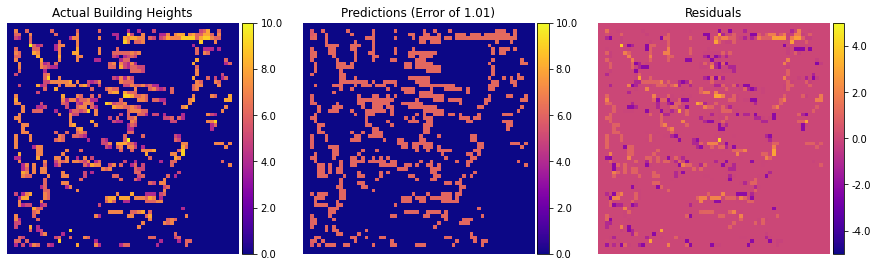

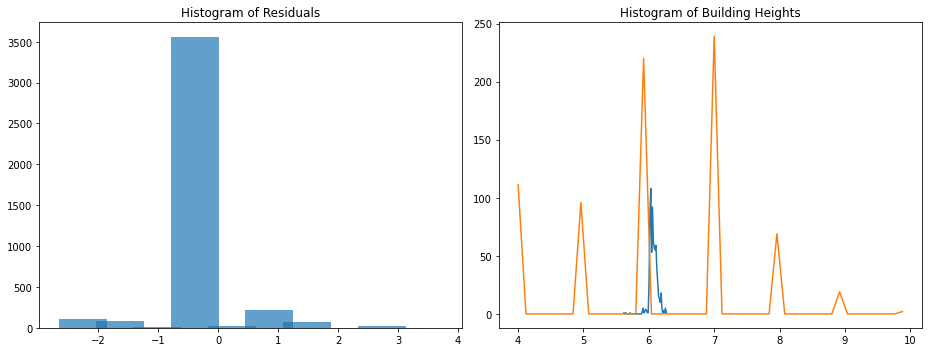

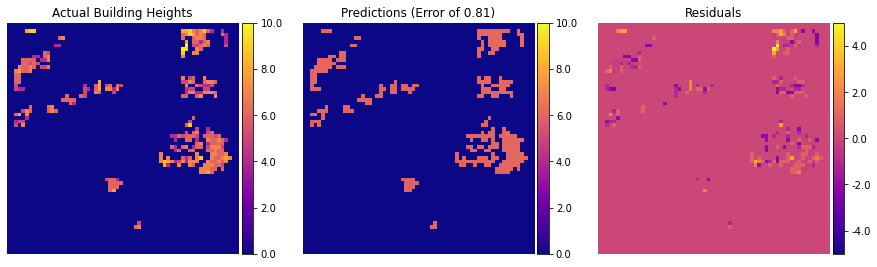

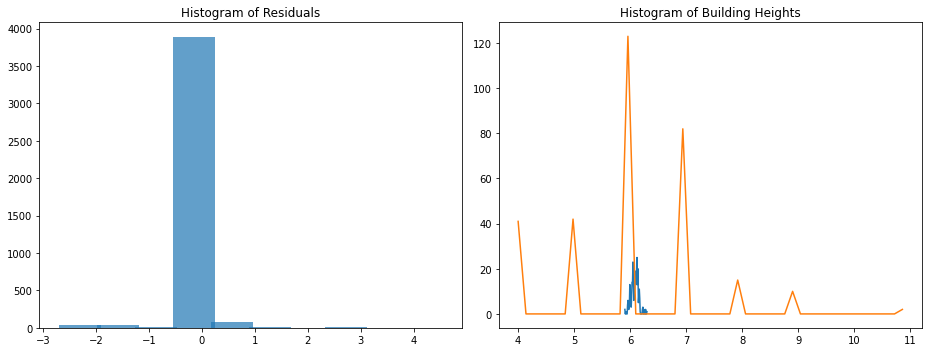

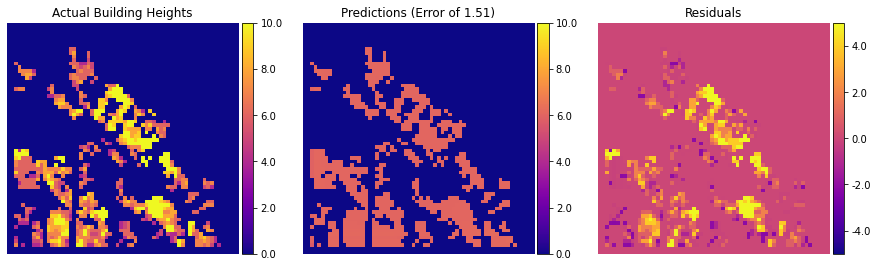

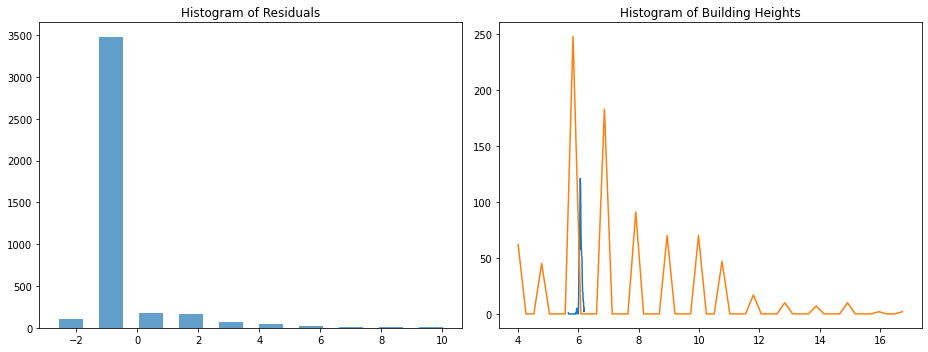

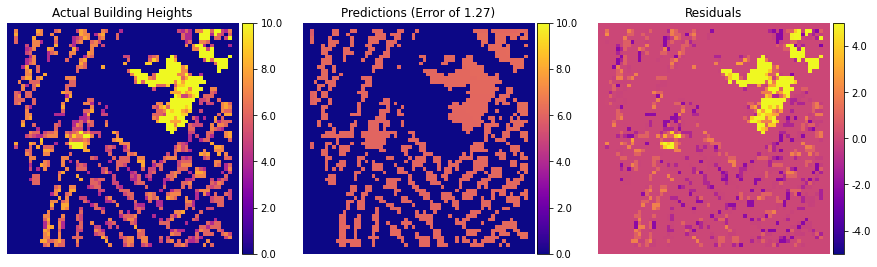

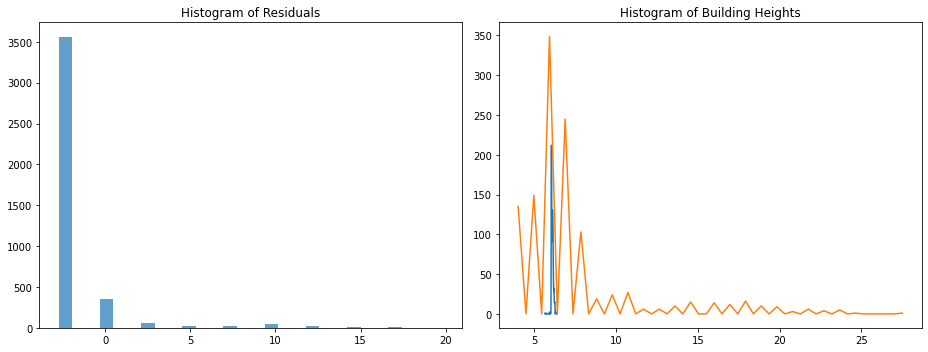

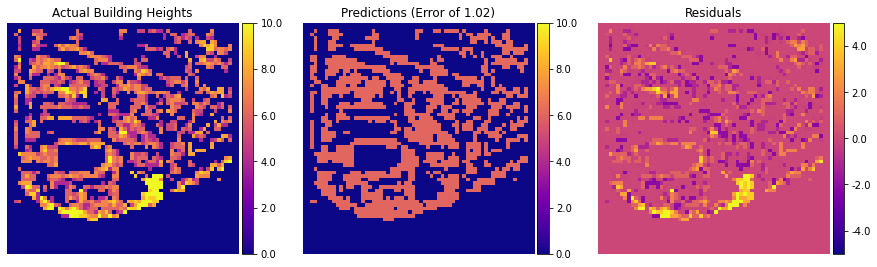

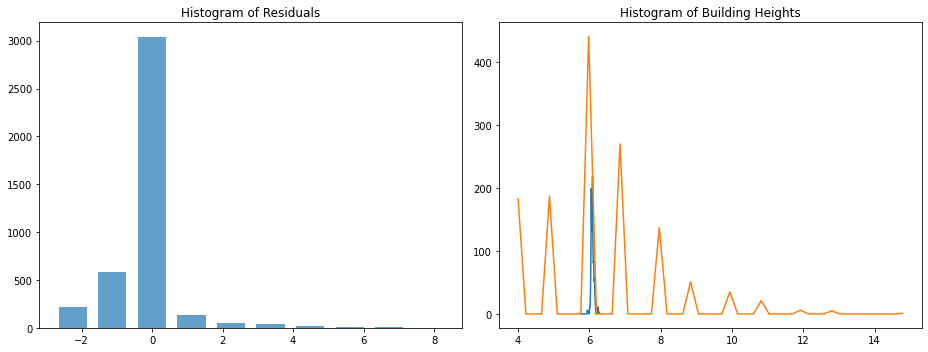

In [6]:
def replace_value_with_frequency_of_occurance(array):

    unique_elements, counts_elements = np.unique(array, return_counts=True)
    mapping = dict(zip(unique_elements, counts_elements))
    
    return np.vectorize(mapping.get)(array)


def weighted_root_mean_squared_error(y_actual, y_pred):
    
    y_actual = y_actual.flatten()
    y_pred   = y_pred.flatten()
    
    y_pred   = y_pred[y_actual > 0]
    y_actual = y_actual[y_actual > 0]
   
    weights = replace_value_with_frequency_of_occurance(y_actual)
    
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))


def visulaize_predictions(model):
    
    augmentations_visualize = A.Compose([
    
        # need to convert uint (0,65535) -> float (0-1)
        A.ToFloat(max_value=65535.0),

    ])
    
    data  = DataGenerator(augmentations=augmentations_visualize, train=False, visualize=False).__getitem__(1)
    preds = model.predict(data[0])
    
    for i in range(len(data[0])):
    
        X = data[0][i]
        y = data[1][i]
        
        pred = preds[i]
        height_image = y
        
        masked_preds = np.where(height_image > 0, pred, 0)
        
        residuals = height_image-masked_preds
        error = round(weighted_root_mean_squared_error(height_image, masked_preds),2)
        
        fig = plt.figure(figsize=(15, 15))
        
        ax1 = fig.add_subplot(1,3,1)
        ax1.axis('off')
        ax1.set_title("Actual Building Heights")
        img1 = ax1.imshow(height_image, vmin=0, vmax=10, cmap='plasma')
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.axis('off')
        ax2.set_title(f"Predictions (Error of {error})")
        img2 = ax2.imshow(masked_preds, vmin=0, vmax=10, cmap='plasma')
        
        
        ax3 = fig.add_subplot(1,3,3)
        ax3.axis('off')
        ax3.set_title(f"Residuals")
        img3 = ax3.imshow(residuals, vmin=-5, vmax=5, cmap='plasma')
        
        fig2 = plt.figure(figsize=(13, 5))
        
        ax4 = fig2.add_subplot(1,2,1)
        ax4.set_title(f"Histogram of Residuals")
        hist, bin_edges = np.histogram(residuals)
        ax4.bar(bin_edges[:-1], hist, alpha=0.7)
        
        
        ax5 = fig2.add_subplot(1,2,2)
        ax5.set_title(f"Histogram of Building Heights")

        height_image = height_image.flatten()
        masked_preds = masked_preds.flatten()

        masked_preds  = masked_preds[height_image > 0]
        height_image  = height_image[height_image > 0]
        
        hist_preds, bin_edges_preds   = np.histogram(masked_preds, 50)
        hist_actual, bin_edges_actual = np.histogram(height_image, 50)
        

        ax5.plot(bin_edges_preds[:-1], hist_preds)
        ax5.plot(bin_edges_actual[:-1], hist_actual)


        
        
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="5%", pad=0.05)
        
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes("right", size="5%", pad=0.05)

        
        fig.colorbar(img1,cax=cax1,  format='%.1f')
        fig.colorbar(img2,cax=cax2,  format='%.1f')
        fig.colorbar(img3,cax=cax3,  format='%.1f')

        plt.tight_layout(h_pad=1)

        
        
visulaize_predictions(model=model)